Replicate EV/REV plots for Octopamine/Rolipram sessions previously generated by Jahangir.

In [17]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy.core.neurons import Neurons
from neuropy.analyses.reactivation import ExplainedVariance
from neuropy.core.epoch import Epoch
from neuropy.core.session import ProcessData

plot_save_dir = Path('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Grants/R01_octopamine_rollipram/Nat_plots')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
sesh_csv = "/data3/Octopamine_Rolipram/Recording_Rats/OCT_ROL_sessions.csv"
sesh_df = pd.read_csv(sesh_csv, header=0)
sesh_df['session'] = pd.Categorical(sesh_df['session'], ['PBS', 'SAL', 'ROL', 'OCT'])
sesh_df = sesh_df.sort_values(["Animal", "session"]).reset_index().drop(columns = "index")
sesh_df


,Animal,session,date,directory,processed
0,A11,PBS,None,None,Y
1,A11,ROL,None,None,Y
2,A11,OCT,None,/data3/Octopamine_Rolipram/Recording_Rats/A11/...,N
3,A14,PBS,2020_02_23,/data3/Octopamine_Rolipram/Recording_Rats/A14/...,Y
4,A14,ROL,2020_02_26,/data3/Octopamine_Rolipram/Recording_Rats/A14/...,Y
5,A14,OCT,2020_02_21,/data3/Octopamine_Rolipram/Recording_Rats/A14/...,Y
6,BG,SAL,2019_10_21,/data3/Octopamine_Rolipram/Recording_Rats/BG/B...,Y
7,BG,ROL,2019_10_19,/data3/Octopamine_Rolipram/Recording_Rats/BG/B...,Y
8,BG,OCT,None,None,N
9,BGU,SAL,2021_08_11,/data3/Octopamine_Rolipram/Recording_Rats/BGU/...,Y


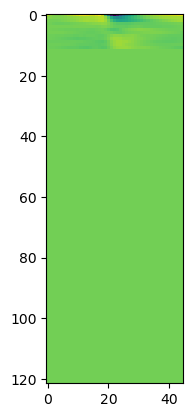

In [27]:
_, ax = plt.subplots()

ax.imshow(neurons_use.waveforms[0])

### Run for all neurons

Running EV for A14 PBS session
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:19<00:00,  6.22it/s]


Running EV for A14 ROL session
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:23<00:00,  5.15it/s]


Running EV for A14 OCT session
Calculating partial correlations for 117 time windows


100%|█████████████████████████████████████████| 117/117 [00:18<00:00,  6.47it/s]
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:187: RuntimeWarning: Mean of empty slice
  self.ev = np.nanmean(partial_corr**2, axis=0)
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:188: RuntimeWarning: Mean of empty slice
  self.rev = np.nanmean(rev_partial_corr**2, axis=0)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Running EV for BG SAL session
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:19<00:00,  6.32it/s]


Running EV for BG ROL session
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:19<00:00,  6.19it/s]


Running EV for BGU SAL session
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:21<00:00,  5.53it/s]


Running EV for BGU ROL session
Calculating partial correlations for 118 time windows


100%|█████████████████████████████████████████| 118/118 [00:23<00:00,  4.96it/s]


Running EV for MR10 PBS session
Calculating partial correlations for 109 time windows


100%|█████████████████████████████████████████| 109/109 [00:17<00:00,  6.18it/s]


Running EV for MR10 ROL session
Calculating partial correlations for 107 time windows


100%|█████████████████████████████████████████| 107/107 [00:17<00:00,  6.21it/s]


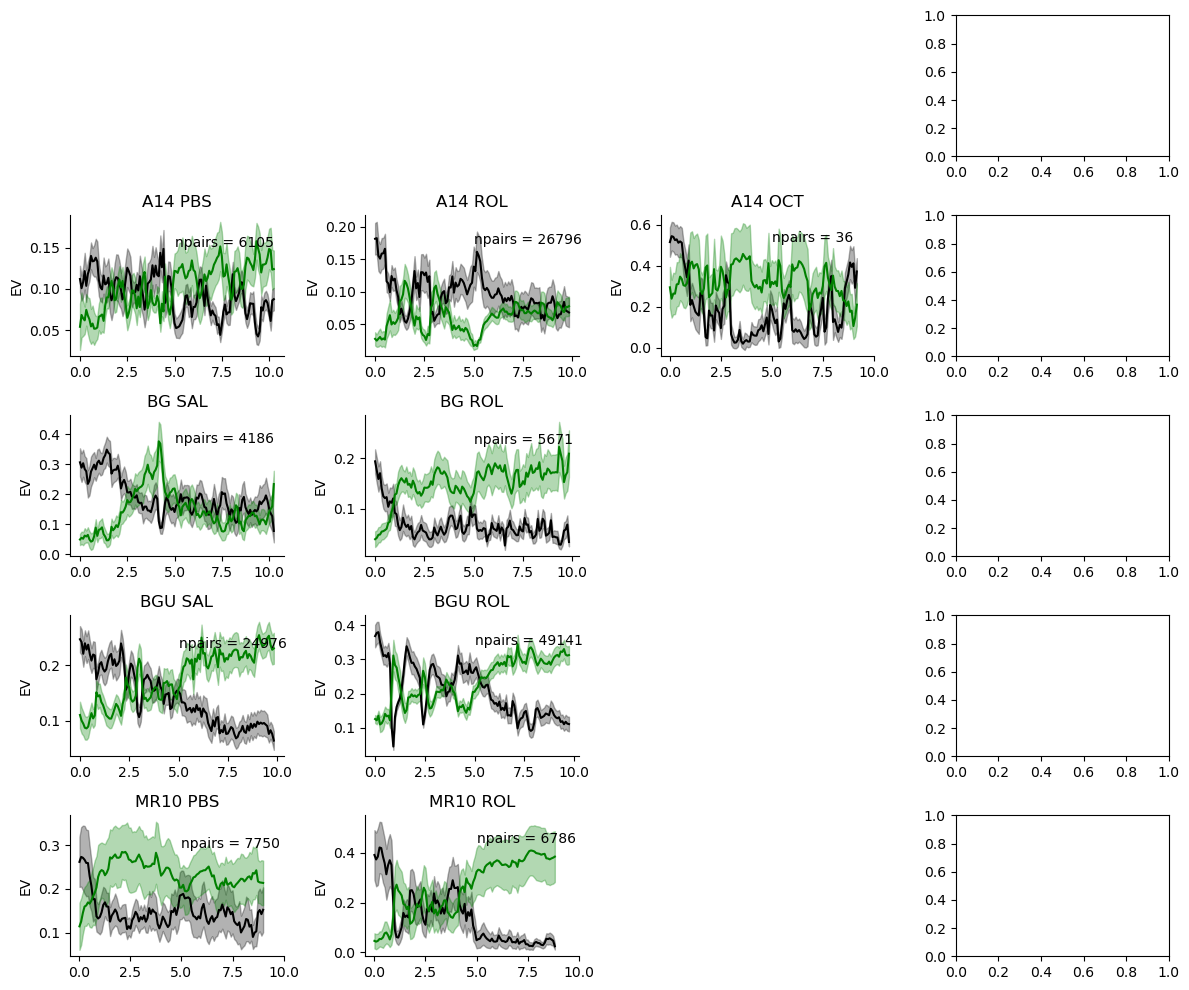

In [21]:
nanimals = len(sesh_df.Animal.unique())
fig, axs = plt.subplots(nanimals, 4, figsize=(12, nanimals * 2), layout='tight')

ev_dict_all = {}
for animal, axrow in zip(sesh_df.Animal.unique(), axs):
    animal_df = sesh_df[sesh_df.Animal == animal]
    for session, ax in zip(animal_df.session, axrow):
        rec_df = animal_df[animal_df.session == session]
        if (rec_df.directory.values[0] == "None") or (rec_df.processed.values[0] == "N"):
            sns.despine(ax=ax, left=True, bottom=True)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            dir_use = Path(str(rec_df["directory"].values[0]))
            neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
            # neurons_use = Neurons.from_dict(neurons_use)
            epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.epoch.npy"))[0])
            print(f"Running EV for {animal} {session} session")
            ev = ExplainedVariance(neurons_use, epochs['maze'].as_array().squeeze(), [epochs['sd'].starts[0], epochs['post'].stops[0]], 
                                   epochs['pre'].as_array().squeeze(), window=900, slideby=300, bin_size=0.250)
            ev_dict_all[f"{animal}_{session}"] = ev
    
            ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.ev, 'k-')
            ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.rev, 'g-')
            ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.ev - ev.ev_std, ev.ev + ev.ev_std, color='k', alpha=0.3)
            ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.rev - ev.rev_std, ev.rev + ev.rev_std, color='g', alpha=0.3)
            ax.set_title(f'{animal} {session}')
            ax.set_xticks([0, 2.5, 5, 7.5, 10])
            ax.set_ylabel('EV')
    
            npairs = int(neurons_use.n_neurons*(neurons_use.n_neurons - 1) /2)
            ax.text(5, ax.get_ylim()[1]*0.8, f"npairs = {npairs}")
            sns.despine(ax=ax)

fig.savefig(plot_save_dir / "EV_all_neurons.pdf")

### Run for pyr neurons only

Running EV for BG SAL session
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:19<00:00,  6.43it/s]


Running EV for BG ROL session
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:18<00:00,  6.52it/s]


Running EV for BGU SAL session
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:18<00:00,  6.46it/s]


Running EV for BGU ROL session
Calculating partial correlations for 118 time windows


100%|█████████████████████████████████████████| 118/118 [00:17<00:00,  6.74it/s]


Running EV for MR10 PBS session
Calculating partial correlations for 109 time windows


100%|█████████████████████████████████████████| 109/109 [00:16<00:00,  6.43it/s]


Running EV for MR10 ROL session
Calculating partial correlations for 107 time windows


100%|█████████████████████████████████████████| 107/107 [00:16<00:00,  6.62it/s]


Running EV for RatA14 PBS session
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:19<00:00,  6.44it/s]


Running EV for RatA14 ROL session
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:21<00:00,  5.65it/s]


Running EV for RatA14 OCT session
Calculating partial correlations for 117 time windows


100%|█████████████████████████████████████████| 117/117 [00:05<00:00, 19.82it/s]
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:187: RuntimeWarning: Mean of empty slice
  self.ev = np.nanmean(partial_corr**2, axis=0)
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:188: RuntimeWarning: Mean of empty slice
  self.rev = np.nanmean(rev_partial_corr**2, axis=0)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


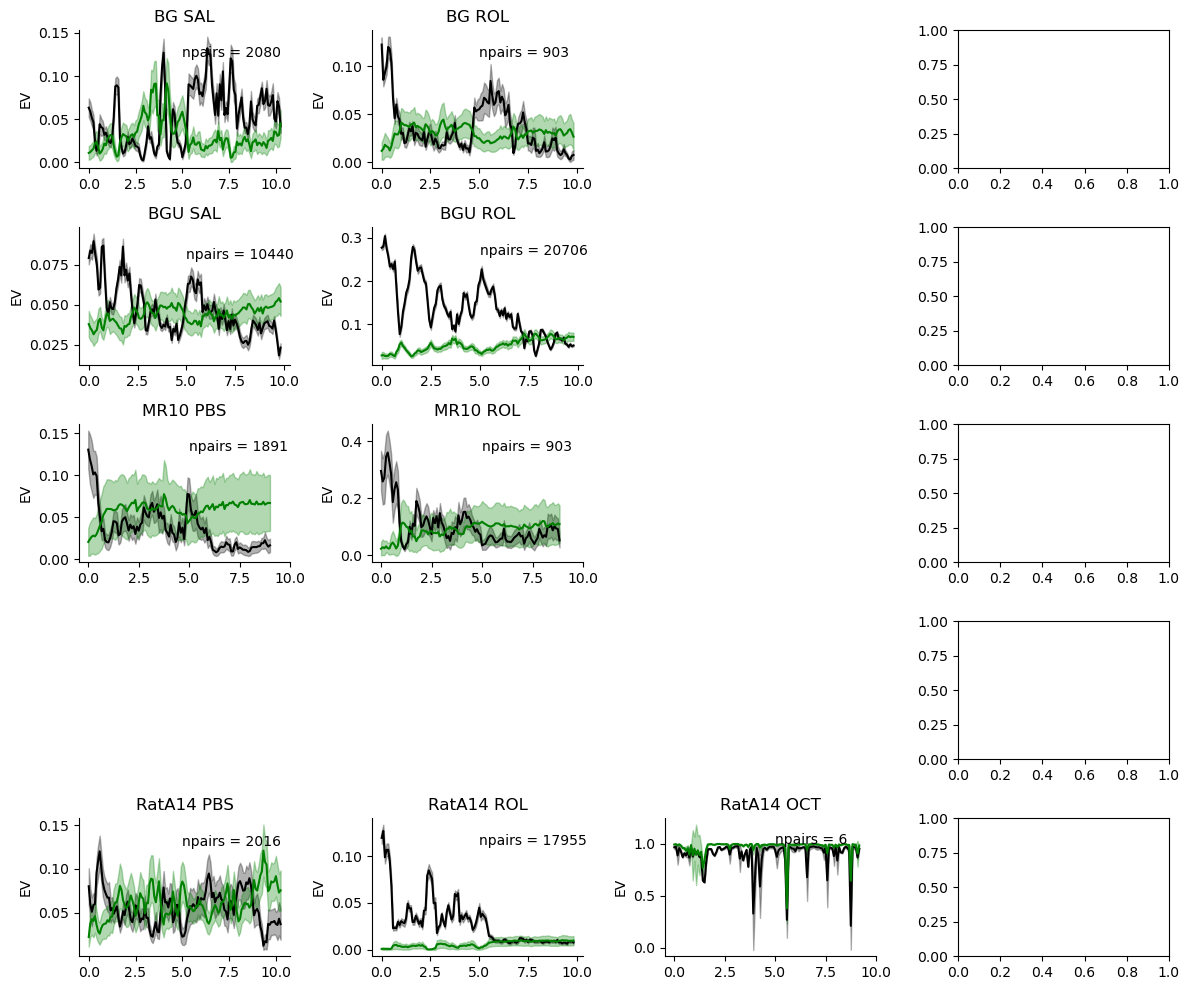

In [147]:
nanimals = len(sesh_df.Animal.unique())
fig, axs = plt.subplots(nanimals, 4, figsize=(12, nanimals * 2), layout='tight')

ev_dict_all = {}
for animal, axrow in zip(sesh_df.Animal.unique(), axs):
    animal_df = sesh_df[sesh_df.Animal == animal]
    for session, ax in zip(animal_df.session, axrow):
        rec_df = animal_df[animal_df.session == session]
        if rec_df.directory.values[0] == "None":
            sns.despine(ax=ax, left=True, bottom=True)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            dir_use = Path(str(rec_df["directory"].values[0]))
            neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
            neurons_use = neurons_use.get_neuron_type("pyr")
            # neurons_use = Neurons.from_dict(neurons_use)
            epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.epoch.npy"))[0])
            print(f"Running EV for {animal} {session} session")
            ev = ExplainedVariance(neurons_use, epochs['maze'].as_array().squeeze(), [epochs['sd'].starts[0], epochs['post'].stops[0]], 
                                   epochs['pre'].as_array().squeeze(), window=900, slideby=300, bin_size=0.250)
            ev_dict_all[f"{animal}_{session}"] = ev
    
            ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.ev, 'k-')
            ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.rev, 'g-')
            ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.ev - ev.ev_std, ev.ev + ev.ev_std, color='k', alpha=0.3)
            ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.rev - ev.rev_std, ev.rev + ev.rev_std, color='g', alpha=0.3)
            ax.set_title(f'{animal} {session}')
            ax.set_xticks([0, 2.5, 5, 7.5, 10])
            ax.set_ylabel('EV')
    
            npairs = int(neurons_use.n_neurons*(neurons_use.n_neurons - 1) /2)
            ax.text(5, ax.get_ylim()[1]*0.8, f"npairs = {npairs}")
            sns.despine(ax=ax)

fig.savefig(plot_save_dir / "EV_pyr_only.pdf")

### Run for pyr only, exclude pairs with similar waveforms

Running EV for BG SAL session
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:19<00:00,  6.45it/s]


Running EV for BG ROL session
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:18<00:00,  6.53it/s]


Running EV for BGU SAL session
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:18<00:00,  6.48it/s]


Running EV for BGU ROL session
Calculating partial correlations for 118 time windows


100%|█████████████████████████████████████████| 118/118 [00:17<00:00,  6.83it/s]


Running EV for MR10 PBS session
Calculating partial correlations for 109 time windows


100%|█████████████████████████████████████████| 109/109 [00:17<00:00,  6.24it/s]


Running EV for MR10 ROL session
Calculating partial correlations for 107 time windows


100%|█████████████████████████████████████████| 107/107 [00:16<00:00,  6.53it/s]


Running EV for RatA14 PBS session
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:19<00:00,  6.38it/s]


Running EV for RatA14 ROL session
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:20<00:00,  5.69it/s]


Running EV for RatA14 OCT session
Calculating partial correlations for 117 time windows


100%|█████████████████████████████████████████| 117/117 [00:01<00:00, 79.11it/s]
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:187: RuntimeWarning: Mean of empty slice
  self.ev = np.nanmean(partial_corr**2, axis=0)
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:188: RuntimeWarning: Mean of empty slice
  self.rev = np.nanmean(rev_partial_corr**2, axis=0)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


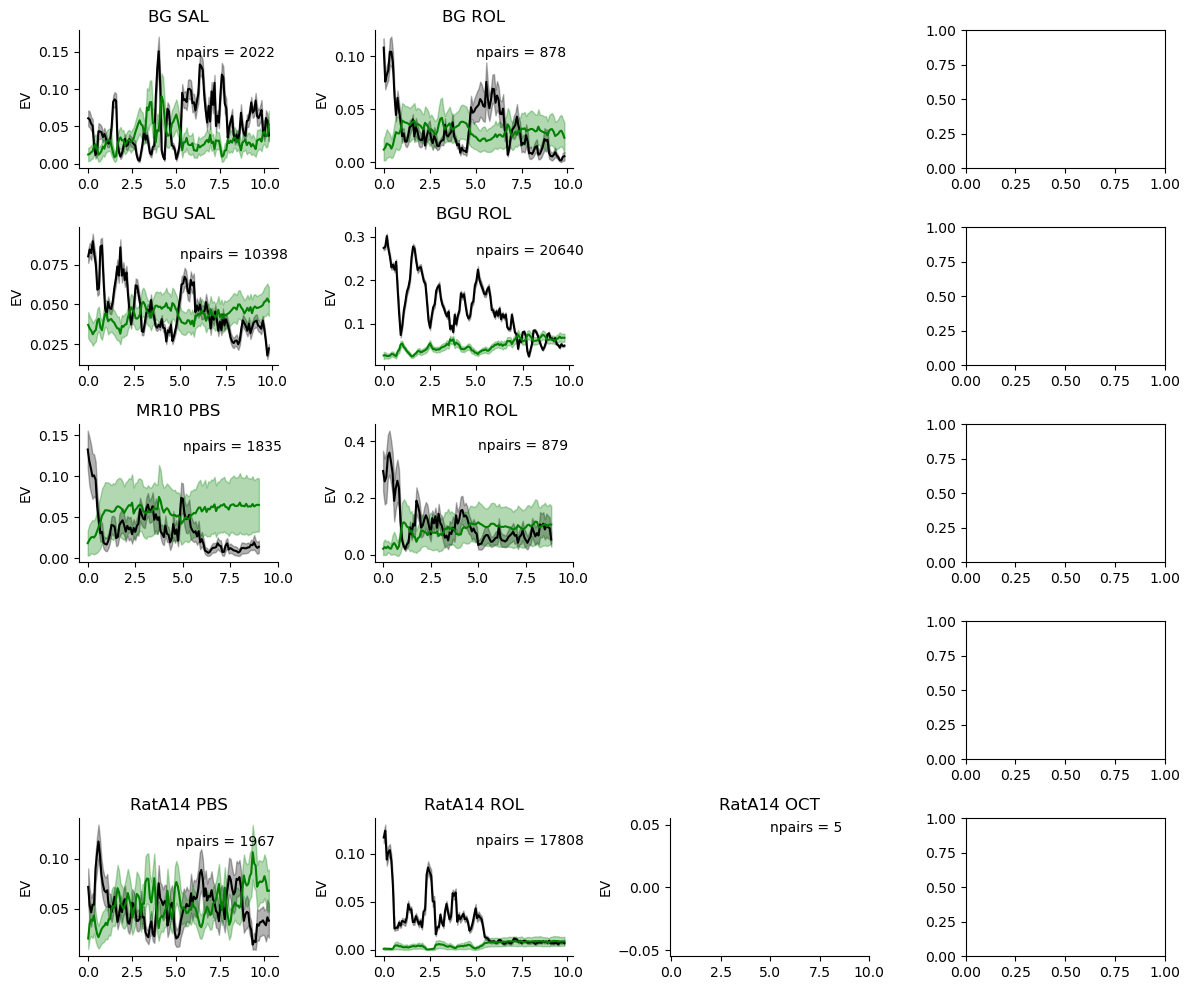

In [163]:
nanimals = len(sesh_df.Animal.unique())
fig, axs = plt.subplots(nanimals, 4, figsize=(12, nanimals * 2), layout='tight')

ev_dict_all = {}
for animal, axrow in zip(sesh_df.Animal.unique(), axs):
    animal_df = sesh_df[sesh_df.Animal == animal]
    for session, ax in zip(animal_df.session, axrow):
        rec_df = animal_df[animal_df.session == session]
        if rec_df.directory.values[0] == "None":
            sns.despine(ax=ax, left=True, bottom=True)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            dir_use = Path(str(rec_df["directory"].values[0]))
            
            neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
            neurons_use = neurons_use.get_neuron_type("pyr")
            wave_similarity = neurons_use.get_waveform_similarity()
            pairs_bool = wave_similarity < 0.8
            
            epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.epoch.npy"))[0])
            print(f"Running EV for {animal} {session} session")
            ev = ExplainedVariance(neurons_use, epochs['maze'].as_array().squeeze(), [epochs['sd'].starts[0], epochs['post'].stops[0]], 
                                   epochs['pre'].as_array().squeeze(), window=900, slideby=300, bin_size=0.250,
                                   pairs_bool=pairs_bool)
            ev_dict_all[f"{animal}_{session}"] = ev
    
            ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.ev, 'k-')
            ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.rev, 'g-')
            ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.ev - ev.ev_std, ev.ev + ev.ev_std, color='k', alpha=0.3)
            ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.rev - ev.rev_std, ev.rev + ev.rev_std, color='g', alpha=0.3)
            ax.set_title(f'{animal} {session}')
            ax.set_xticks([0, 2.5, 5, 7.5, 10])
            ax.set_ylabel('EV')
    
            # npairs = int(neurons_use.n_neurons*(neurons_use.n_neurons - 1) /2)
            npairs = int(np.triu(pairs_bool, 1).reshape(-1).sum())
            ax.text(5, ax.get_ylim()[1]*0.8, f"npairs = {npairs}")
            sns.despine(ax=ax)

fig.savefig(plot_save_dir / "EV_pyr_only_wave_exclude.pdf")

In [162]:
pairs_bool

array([[ True, False,  True,  True],
       [False,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [158]:
neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
neurons_use.get_neuron_type(["1", "pyr"]).neuron_type

array(['pyr', '1', 'pyr', 'pyr', 'pyr'], dtype='<U5')

[]

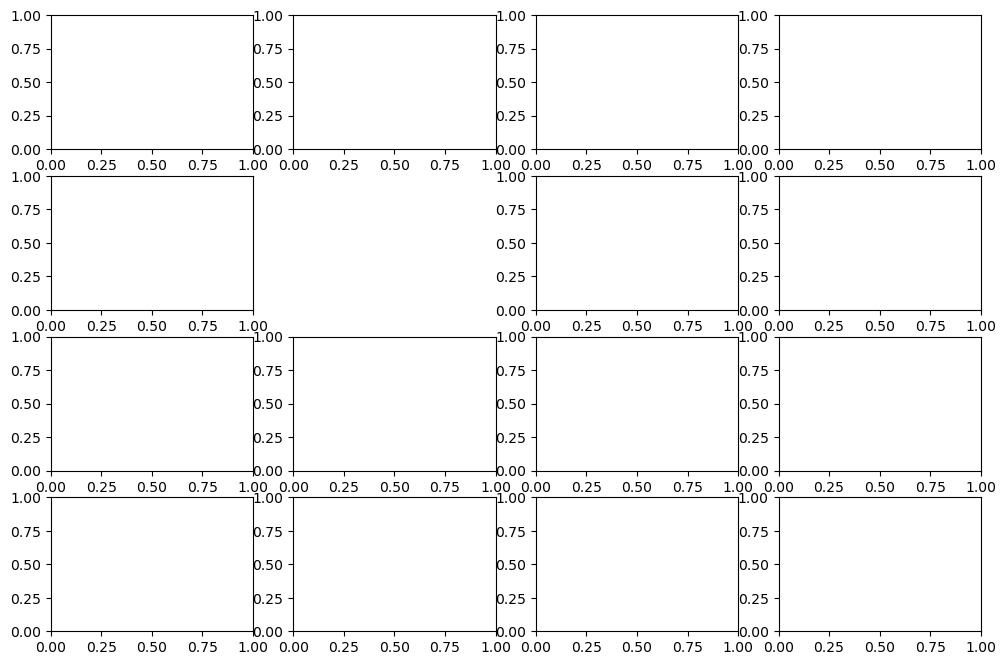

In [95]:
fig, axs = plt.subplots(nanimals, 4, figsize=(12, nanimals * 2))
npairs = int(neurons_use.n_neurons*(neurons_use.n_neurons - 1) /2)
sns.despine(ax=axs[1][1], left=True, bottom=True)
axs[1][1].set_xticks([])
axs[1][1].set_yticks([])